In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

In [ ]:
# we dont really need info but this is an informationsgesellschaft so we take it on annieway :))
(ood_train, ood_test), info = tfds.load("genomics_ood", split=["train[:100000]", "test[:1000]"], shuffle_files=True, as_supervised=True, with_info=True)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [ ]:
# we wanna be a hot one
def make_me_hot(seq, label):
  translate = {'A':'0', 'C': '1', 'G':'2', 'T':'3'}
  seq = tf.strings.bytes_split(seq)
  for key in translate:
    seq = tf.strings.regex_replace(seq, key, translate[key])
  seq = tf.strings.to_number(seq, tf.int32)
  seq = tf.one_hot(seq, 4)
  seq = tf.reshape(seq, (-1,))

  label = tf.one_hot(label, 10)
  return (seq, label)

In [ ]:
#make dem hot, there's enough hotness for everyone <3
hot_train = ood_train.map(make_me_hot).batch(64)
hot_train = hot_train.prefetch(2)
hot_test = ood_test.map(make_me_hot).batch(64)
hot_test = hot_test.prefetch(2)


for data in hot_train:
  #print(data)
  print(tf.shape(data[0]))
  break


tf.Tensor([  64 1000], shape=(2,), dtype=int32)


In [ ]:
#model class with two hidden layers (256) and one output layer (10)
#very narrow ideal of model types only 

class MLP(Model):
    
    def __init__(self):
        # And also call the super init again. This is very important, yes it is! Makes you super (+ hot)
        super(MLP, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=256 , activation=tf.keras.activations.sigmoid)
        self.hidden_2 = tf.keras.layers.Dense(units=256 , activation=tf.keras.activations.sigmoid)
        self.loudputputput = tf.keras.layers.Dense(units=10 , activation=tf.keras.activations.softmax)
        
    def call(self, x):
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.loudputputput(x)
        return x


In [ ]:
#train model for bums-tums-n-legs

def train_step(model, input, target, loss_function, optimizer):
  # step aerobic
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # aerobic performance

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  #judge's performance scores
  return test_loss, test_accuracy
  

In [ ]:
tf.keras.backend.clear_session()

# hyper hyper param tsss
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

train_dataset = hot_train
test_dataset = hot_test

# cast a model for our agency Run(a?)WayTensor using very narrow criteria
model = MLP()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize portfolio for later photo shoots
train_losses = []

test_losses = []
test_accuracies = []

test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on catwalk once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

#train for num_epochs before high fashion season starts
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training model (and checking in as a personal coach)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #casting model
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


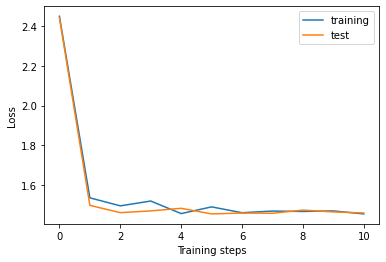

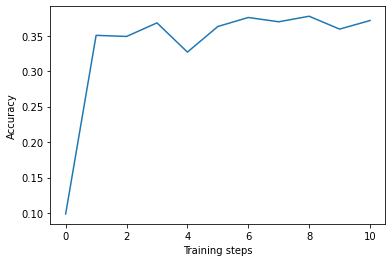

In [ ]:
# photoshoot model 
# show monthly profit taken from model (#menschenhandel #uncool)

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#TODO publish photos in playboy magazine without consent